In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
from pandas.plotting import scatter_matrix
import scipy.stats as stats
import seaborn as sns
from nltk.util import ngrams
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import  SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import datasets, linear_model, pipeline, feature_extraction, ensemble, neighbors, tree
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, balanced_accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
import string
import sys
import warnings
warnings.filterwarnings("ignore")
import pprint

In [73]:
from src.item_recommender import ItemRecommender

In [2]:
# importing the data
initial_data = pd.read_csv('data/winemag-data-130k-v2.csv')

In [3]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [4]:
initial_data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [5]:
# dropping column information I do not need or want to use
new_df = initial_data.drop(['region_1', 'region_2', 'designation', 'province', 'taster_twitter_handle'], axis=1)

In [6]:
new_df.head()

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.",87,NaN,Kerin O’Keefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's already drinkable, although it will certainly be better from 2016.",87,15.0,Roger Voss,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and rind dominate. Some green pineapple pokes through, with crisp acidity underscoring the flavors. The wine was all stainless-steel fermented.",87,14.0,Paul Gregutt,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom start off the aromas. The palate is a bit more opulent, with notes of honey-drizzled guava and mango giving way to a slightly astringent, semidry finish.",87,13.0,Alexander Peartree,St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore),Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this comes across as rather rough and tannic, with rustic, earthy, herbal characteristics. Nonetheless, if you think of it as a pleasantly unfussy country wine, it's a good companion to a hearty winter stew.",87,65.0,Paul Gregutt,Sweet Cheeks 2012 Vintner's Reserve Wild Child Block Pinot Noir (Willamette Valley),Pinot Noir,Sweet Cheeks


In [7]:
new_df.isna().sum()

Unnamed: 0         0
country           63
description        0
points             0
price           8996
taster_name    26244
title              0
variety            1
winery             0
dtype: int64

In [8]:
new_df = new_df.drop_duplicates('description', keep='first')

In [9]:
new_df.shape

(119955, 9)

In [10]:
new_df.isna().sum()

Unnamed: 0         0
country           59
description        0
points             0
price           8388
taster_name    24912
title              0
variety            1
winery             0
dtype: int64

In [11]:
new_df.dropna(axis=0, inplace=True)
new_df.shape

(88244, 9)

In [12]:
new_df.isna().sum()

Unnamed: 0     0
country        0
description    0
points         0
price          0
taster_name    0
title          0
variety        0
winery         0
dtype: int64

In [13]:
country_count = new_df['country'].value_counts()

country_count

US                        34261
France                    16041
Italy                      9117
Spain                      5985
Portugal                   4497
Chile                      4019
Argentina                  3498
Austria                    2527
Germany                    1924
Australia                  1887
New Zealand                1143
South Africa               1123
Israel                      448
Greece                      426
Canada                      223
Bulgaria                    132
Hungary                     127
Romania                     102
Uruguay                      98
Turkey                       81
Georgia                      74
Slovenia                     70
Croatia                      68
Mexico                       63
England                      59
Moldova                      56
Brazil                       44
Lebanon                      32
Morocco                      24
Peru                         16
Ukraine                      14
Czech Re

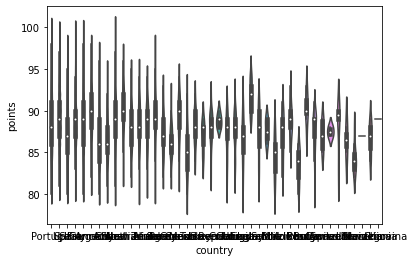

In [14]:
ax = sns.violinplot(x='country', y='points' ,data=new_df)

In [15]:
# country_count = new_df['country'].value_counts()
# country_count = country_count[:15,]
# # groups = new_df.groupby('country').filter(lambda x: len(x) >= 200).reset_index()
# plt.figure(figsize=(15,8))
# sns.boxplot(x=new_df['country'], y=new_df['points'].mean())
# plt.title('How Countries Rated Wine')
# plt.ylabel('Wine Ratings', fontsize=16)
# plt.xlabel('Country', fontsize=16)
# plt.show()

# TF IDF Recommendation

In [16]:
# Custom list of stop words

extras = ['red', 'white', 'Cabernet Sauvignon', 'Sauvignon Blanc', 'Pinot Noir',
       'Chardonnay', 'Tempranillo', 'Malbec', 'Syrah', 'Sangiovese',
       'Riesling', 'Nebbiolo', 'Pinot Gris', 'Glera', 'Viognier',
       'Pinot Grigio', 'Cabernet Franc', 'Zinfandel', 'Barbera',
       'Albariño', 'Bordeaux-style Red Blend', 'Gewürztraminer', 'Merlot',
       'Grüner Veltliner', 'Pinot Blanc', 'Shiraz', 'Chenin Blanc', 'merlot', 'pinot', 'chardonnay','noir','cabernet','sauvignon', 'bordeaux','riesling','syrah','viognier', 'wine', 'flavors', 'fruit', 'palate','finish','aromas','notes','drink','years','good','like','nose','ripe','acidity',]
stop = set(stopwords.words('english'))
stop.update(extras)

In [56]:
sample = new_df.sample(100).reset_index(drop=True)
sample.head()

,Unnamed: 0,country,description,points,price,taster_name,title,variety,winery
0,72348,Italy,"This internationally-styled Verdicchio opens with aromas of oak, butterscotch and vanilla. The palate is also dominated by wood sensations, along with notes of apple, butterscotch and lemon peel in the background.",86,35.0,Kerin O’Keefe,Santa Barbara 2011 Riserva Stefano Antonucci (Verdicchio dei Castelli di Jesi Classico),Verdicchio,Santa Barbara
1,104278,Austria,"A haze of hazelnut and wood smoke envelopes the poised concentrated lemon and green-pear fruit on the palate. There is incisive freshness and a concentrated core with a downright lip-smacking finish. It would be a waste to drink this now when everything about this bundled, energetic wine still needs to unfurl. Give this time. Drink 2020–2030.",93,70.0,Anne Krebiehl MW,Bründlmayer 2015 Vincents Spiegel Reserve Grüner Veltliner (Kamptal),Grüner Veltliner,Bründlmayer
2,43188,US,"One of Schramsberg's younger releases, and made from all white grapes, this wine has tantalizing aromas of vanilla, apple and light toast that lead to layered and creamy flavors. A nice brisk balance with good acidity underlies the spice and fruit.",90,39.0,Jim Gordon,Schramsberg 2012 Blanc de Blancs Sparkling (North Coast),Sparkling Blend,Schramsberg
3,22030,Italy,"Subdued aromas of yellow flower, orchard fruit and a whiff of nut lift out of the glass. The palate seems rather evolved, offering suggestions dried citrus zest and a hint of baked yellow apple. It closes on a bitter almond note.",86,22.0,Kerin O’Keefe,La Boatina 2015 Pinot Grigio (Friuli Isonzo),Pinot Grigio,La Boatina
4,121496,Canada,"A reserve-level Merlot, this is blended with 9% Cabernet Franc and 2% Syrah, then barrel-aged for 18 months in new, one- and two-year-old French oak barrels. Oaky, smoky, charred and tannic, it's a bit of a bruiser. But dig down and you'll find cassis, black cherry, coffee, cola, licorice and tar—in short, a compelling range of dark flavors, all well-integrated. Drink soon.",90,30.0,Paul Gregutt,Tinhorn Creek 2011 Oldfield Series Merlot (Okanagan Valley),Merlot,Tinhorn Creek


In [75]:
from sklearn.metrics.pairwise import cosine_similarity

all_descriptions = new_df[['description']]

# Initiate tf idf vectorizer
tf = TfidfVectorizer(stop_words=stop)

tfidf_matrix = tf.fit_transform(sample.description)

cosine_similarity = cosine_similarity(tfidf_matrix)


In [79]:
wine_recommender = ItemRecommender()
wine_recommender.fit(tfidf_matrix, sample.description)

In [60]:
similar = {}

In [61]:
for i in range(len(cosine_similarity)):
    # Now we'll sort each element in cosine_similarity and get the indexes of the wine reviews.
    similar_indices = cosine_similarity[i].argsort()[:-50:-1]
    # After that, we'll store in similarities each name of the 50 most similar wines.
    # Except the first one that is the same wine.
    similar[sample['description'].iloc[i]] = [(cosine_similarity[i][x], sample['description'][x], sample['description'][x]) for x in similar_indices][1:]

In [64]:
class ContentBasedRecommender:
    def __init__(self, matrix):
        self.matrix_similar = matrix
    def _print_message(self, wine, recommended_wine):
        rec_items = len(recommended_wine)
        print(f'The {rec_items} recommended wine for {wine} are:')
        for i in range(rec_items):
            print(f"Number {i+1}:")
            print(f"{recommended_wine[i][1]} by {recommended_wine[i][2]} with {round(recommended_wine[i][0], 3)} similarity score")
            print("--------------------")
    def recommend(self, recommendation):
        # Get wine to find recommendations for
        song = recommendation['wine_name']
        # Get number of wines to recommend
        number_wines = recommendation['number_wines']
        # Get the number of wines most similars from matrix similarities
        recommended_wine = self.matrix_similar[wine][:number_wines]
        # print each item
        self._print_message(wine=wine, recommended_wine=recommended_wine)

In [69]:
dict_items = similar.items()
first_two = list(dict_items)[:2]
first_two

[('This internationally-styled Verdicchio opens with aromas of oak, butterscotch and vanilla. The palate is also dominated by wood sensations, along with notes of apple, butterscotch and lemon peel in the background.',
  [(0.126323442891641,
    'Fresh, full bodied and juicy, this has flavors of dusty, dark plum and chocolate. It was aged in both French and American oak, which has added a background note of tobacco and vanilla on the palate, particularly on the finish.',
    'Fresh, full bodied and juicy, this has flavors of dusty, dark plum and chocolate. It was aged in both French and American oak, which has added a background note of tobacco and vanilla on the palate, particularly on the finish.'),
   (0.10668124249713629,
    "Heavy oak is a major theme on this full-bodied Malbec that's cool and woody to start, with aromas of vanilla and sweet plastic along with ripe blackberry and cassis. Wall-to-wall huge in mouthfeel, this tastes mostly of toasty oak, with blackened, charred ber

In [70]:
print(ContentBasedRecommender)

<class '__main__.ContentBasedRecommender'>
